In [1]:
import csv
import glob
import itertools
import multiprocessing as mp
import os.path
import pickle
import pprint
import time
from io import TextIOWrapper
from multiprocessing import Manager, Pool, Process, Queue
from os import path
from zipfile import ZipFile

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from db import NABat_DB
from PIL import Image
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
pp = pprint.PrettyPrinter(indent=4)

# Open the database connection.
db = NABat_DB(p="db0")

# List the bat species we are considering in this model.
species = db.query(
    'select id, species_code, available from species where available = 1;')
class_names = [c[1] for c in species]
print(species)

[Row(id=1, species_code='ANPA', available=1), Row(id=4, species_code='COTO', available=1), Row(id=5, species_code='EPFU', available=1), Row(id=8, species_code='EUPE', available=1), Row(id=10, species_code='IDPH', available=1), Row(id=11, species_code='LANO', available=1), Row(id=12, species_code='LABL', available=1), Row(id=13, species_code='LABO', available=1), Row(id=14, species_code='LACI', available=1), Row(id=16, species_code='LAIN', available=1), Row(id=17, species_code='LASE', available=1), Row(id=25, species_code='MYAU', available=1), Row(id=26, species_code='MYCA', available=1), Row(id=27, species_code='MYCI', available=1), Row(id=28, species_code='MYEV', available=1), Row(id=29, species_code='MYGR', available=1), Row(id=31, species_code='MYLE', available=1), Row(id=32, species_code='MYLU', available=1), Row(id=33, species_code='MYSE', available=1), Row(id=34, species_code='MYSO', available=1), Row(id=35, species_code='MYTH', available=1), Row(id=37, species_code='MYVO', avail

In [18]:
# Given a model and dataset, query our database to return pulse-level predictions.
def get_predictions_pulse(model, draw):
    pulses = db.fastQuery(
        'select count(*) from file f join pulse p on p.file_id = f.id join species s on s.id = f.manual_id where draw = ? and available = 1 and f.grts_id != 0;', (draw,))
    return db.fastQuery("""
    
    with max_conf as (
            select
                p.pulse_id,
                p.confidence
            from
                prediction p
            where 
                p.model_name = ?
            order by 
                p.confidence DESC
        )
        
        select
            f.id,
            f.name,
            s.species_code,
            max(p.confidence)
        from 
            max_conf
        join
            prediction p on p.pulse_id = max_conf.pulse_id and p.model_name = ?
        join 
            species s on s.id = p.species_id and available = 1
        join 
            pulse on pulse.id = p.pulse_id
        join
            file f on f.id = pulse.file_id and f.grts_id != 0
        join
            species_grts sl on sl.grts_id = f.grts_id and sl.species_id = p.species_id
        where 
            draw = ?
        group by
            p.pulse_id
    """, (model, model, draw)), pulses[0][0]

# Given a model and dataset, query our database to return pulse-level predictions
# aggregated up to the file level, using only pulse predictions with a confidence > min_confidence.
def get_predictions_file(model, draw, min_confidence=0):
    files = db.fastQuery(
        'select count(*) from file f join species s on s.id = f.manual_id where draw = ? and available = 1 and f.grts_id != 0;', (draw,))

    return db.fastQuery("""
    
        with samples as (
            select
                file_id,
                count(*) pc
            from 
                pulse p
            group by 1
        ) 
        , conf as (
            select
                p.file_id,
                pp.species_id,
                count(p.id) num_samples,
                sum(confidence)/(pc) sc
            from
                pulse p
            join
                prediction pp on pp.pulse_id = p.id and pp.model_name = ?
            join 
                samples on samples.file_id = p.file_id
            join 
                species s on s.id = pp.species_id and available = 1
             where 
                pp.confidence > ?
            group by
                p.file_id, pp.species_id
        )
        
        , xx as (
        select
            conf.file_id,
            name,
            s.species_code,
            max(conf.sc) conf,
            f.grts_id,
            s.id as species_id
        from 
            conf
        join
            file f on f.id = conf.file_id and f.grts_id != 0
        join 
            species s on s.id = conf.species_id and available = 1
        
        where 
            draw = ?
        group by 
            1,2 
            
        )
        
    select * from xx 
        join
          species_grts sl on sl.grts_id = xx.grts_id and sl.species_id = xx.species_id
    """, (model, min_confidence, draw)), files[0][0]


# Plot a confusion matrix.
def plot_confusion_matrix(cm, class_names, i, draw):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(18, 18))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Identification Rate: {} M-{}".format(draw, i))
    # plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)
                   [:, np.newaxis], decimals=3)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 1.5

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > 0.70 else "black"
        if cm[i, j] > 0.001:
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        else:
            plt.text(j, i, '0', horizontalalignment="center", color=color)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.ioff()
    plt.show()

In [19]:
# Define the model, dataset, and confidence threshold.
draw = 'test'
model = '1'
thresh = 0.0

# Store aggregated output.
test_labels = []
test_predictions = []
incorrect_confidences = [] ### wrong_predictions and correct_predictions might be better?
correct_confidences = []

predictions, pulse_count = get_predictions_pulse(model, draw)
predictions, pulse_count

([(92196, 'TABR-102604', 'LACI', 0.2710880637168884),
  (92196, 'TABR-102604', 'LACI', 0.1559954732656479),
  (92196, 'TABR-102604', 'LACI', 0.16563062369823456),
  (92196, 'TABR-102604', 'LACI', 0.12938739359378815),
  (92196, 'TABR-102604', 'LACI', 0.19197194278240204),
  (92196, 'TABR-102604', 'LACI', 0.2478872537612915),
  (92196, 'TABR-102604', 'LACI', 0.24788916110992432),
  (92196, 'TABR-102604', 'LACI', 0.25531432032585144),
  (92196, 'TABR-102604', 'LACI', 0.1906343400478363),
  (92196, 'TABR-102604', 'LACI', 0.2096596658229828),
  (92196, 'TABR-102604', 'LACI', 0.18839193880558014),
  (92196, 'TABR-102604', 'LACI', 0.30710986256599426),
  (92196, 'TABR-102604', 'LACI', 0.23871208727359772),
  (93963, 'COTO-102724', 'LASE', 0.092054583132267),
  (93963, 'COTO-102724', 'EPFU', 0.019640939310193062),
  (93963, 'COTO-102724', 'EPFU', 0.01823662593960762),
  (93963, 'COTO-102724', 'EPFU', 0.03057309053838253),
  (93963, 'COTO-102724', 'LACI', 0.0348355732858181),
  (93963, 'COTO-1

In [27]:
predictions[-1], predictions[0]

((109439, 'MYEV-17385', 'NYHU', 0.048921216279268265),
 (92196, 'TABR-102604', 'LACI', 0.2710880637168884))

In [21]:
rejected = pulse_count - len(predictions)

# Loop through each pulse prediction.
for p in predictions:
    if p[-1] >= thresh:
        test_labels.append(p[1].split('-')[-2])
        test_predictions.append(p[2])

        if test_labels[-1] == test_predictions[-1]:
            correct_confidences.append(p[-1])
        else:
            incorrect_confidences.append(p[-1])
    else:
        rejected += 1

print('Rejected {}/{} - {:0.2f}'.format(rejected,
      pulse_count, 100 * (rejected/pulse_count)))


# Print the chart.
cr = classification_report(
    test_labels, test_predictions,  labels=class_names, output_dict=False)
print(cr, '\n\n')

# Plot the matrix.
cr = classification_report(
    test_labels, test_predictions, labels=class_names, output_dict=True)
cr_sorted_keys = sorted(class_names, key=lambda x: (
    cr[x]['recall']), reverse=True)
cr

Rejected 65552/68529 - 95.66
              precision    recall  f1-score   support

        ANPA       0.00      0.00      0.00         0
        COTO       0.00      0.00      0.00        30
        EPFU       0.00      0.00      0.00         0
        EUPE       0.00      0.00      0.00         7
        IDPH       0.00      0.00      0.00         0
        LANO       0.00      0.00      0.00        15
        LABL       0.00      0.00      0.00         0
        LABO       0.00      0.00      0.00         0
        LACI       0.16      0.62      0.26        26
        LAIN       0.00      0.00      0.00         0
        LASE       0.00      0.00      0.00         0
        MYAU       0.00      0.00      0.00         0
        MYCA       0.00      0.00      0.00         0
        MYCI       0.00      0.00      0.00         0
        MYEV       0.26      0.24      0.25       138
        MYGR       0.00      0.00      0.00       637
        MYLE       0.00      0.00      0.00        4

/Users/adityakrishna/miniforge3/envs/nabat_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adityakrishna/miniforge3/envs/nabat_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adityakrishna/miniforge3/envs/nabat_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

{'ANPA': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'COTO': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 30},
 'EPFU': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'EUPE': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7},
 'IDPH': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'LANO': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15},
 'LABL': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'LABO': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'LACI': {'precision': 0.16161616161616163,
  'recall': 0.6153846153846154,
  'f1-score': 0.256,
  'support': 26},
 'LAIN': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'LASE': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'MYAU': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'MYCA': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0

In [22]:
cm = metrics.confusion_matrix(
    test_labels, test_predictions, labels=cr_sorted_keys, normalize='true')

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_51401/3130099315.py:124: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)


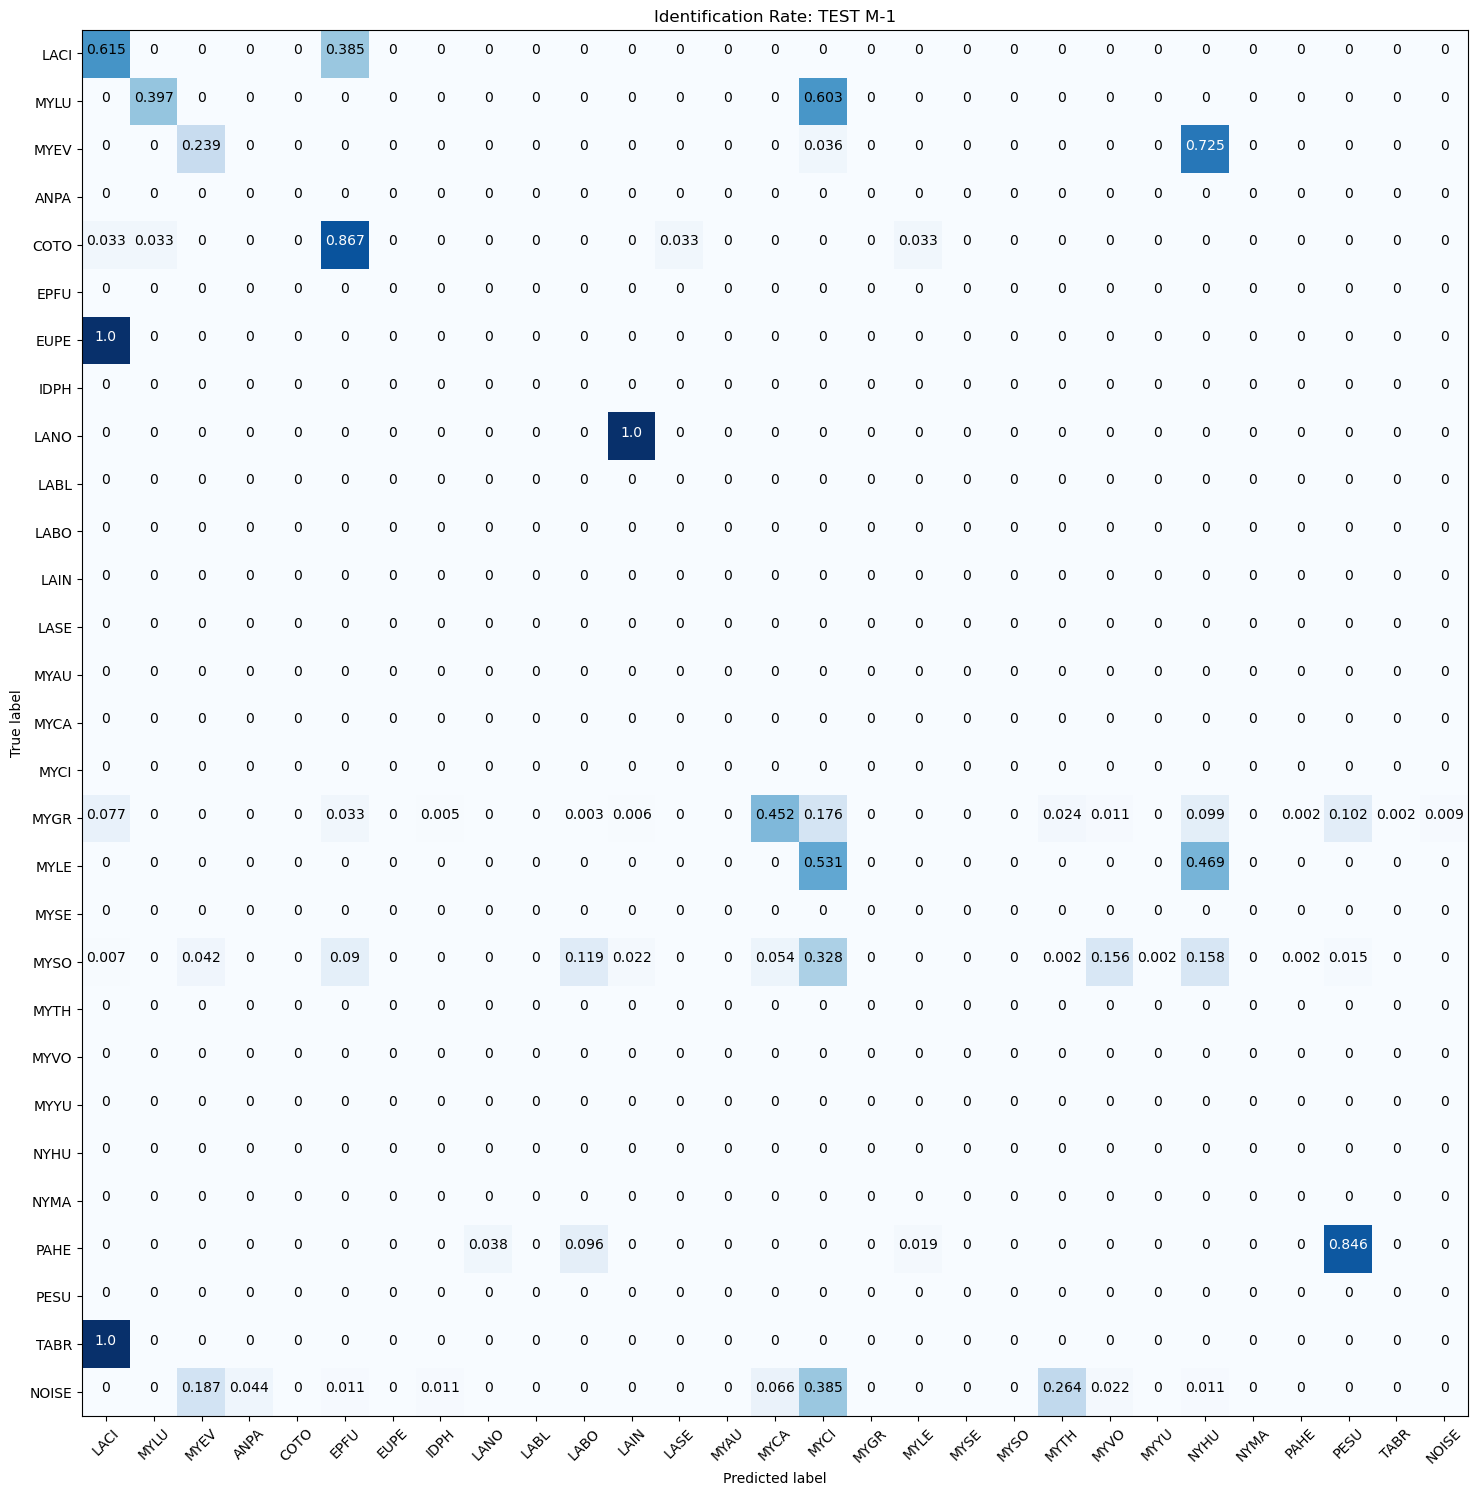

In [23]:
plot_confusion_matrix(cm, class_names=cr_sorted_keys,
                      i=model, draw=draw.upper())



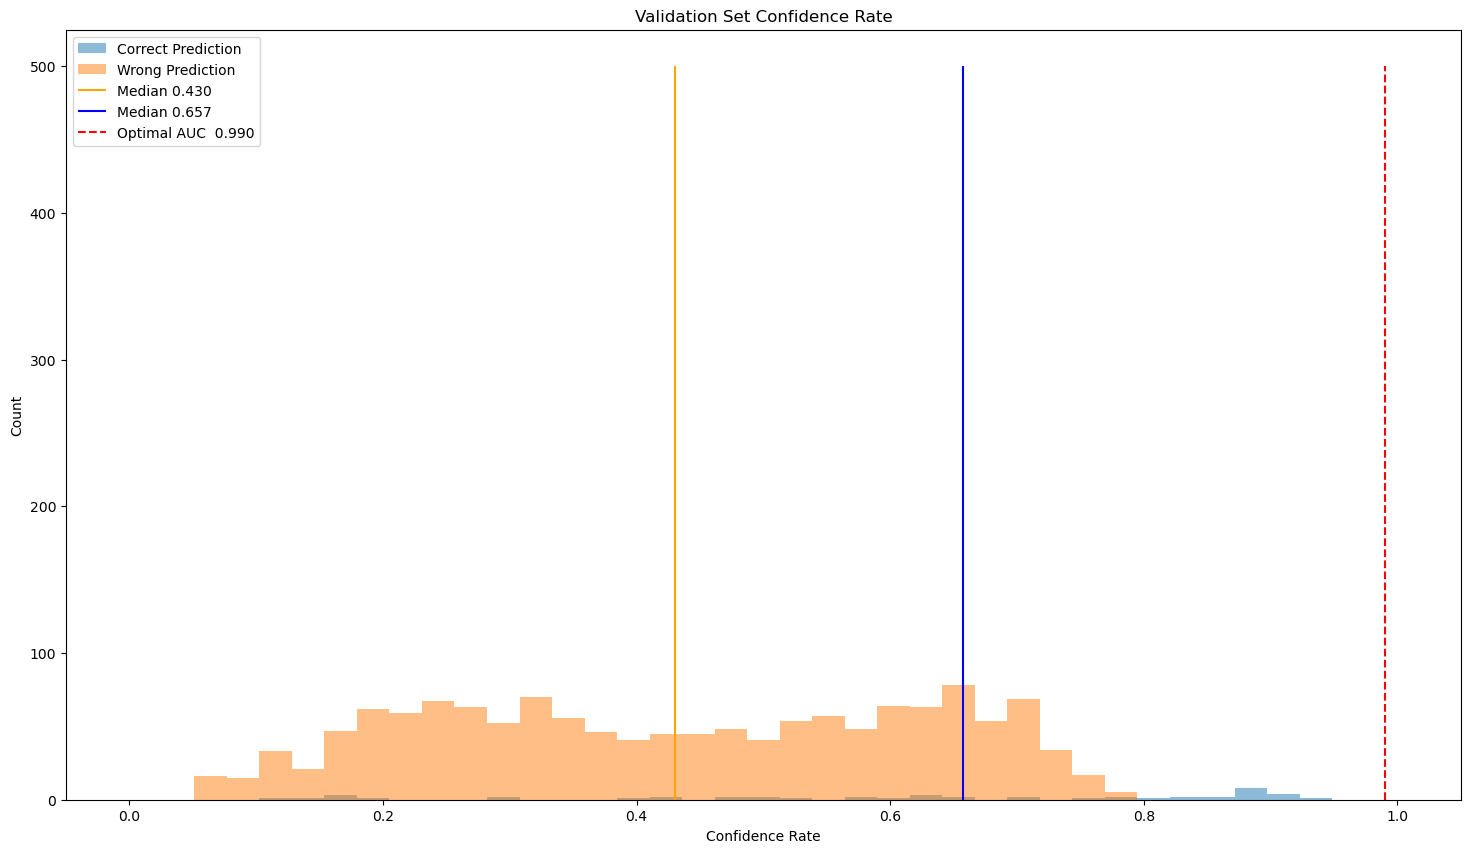

In [50]:

# Plot the curve, based on confidence and split of correct versus wrong guesses.
plt.close('all')
figure = plt.figure(figsize=(18, 10))

sum_wrong = []
sum_correct = []
x = 0
moving_rate = 0.01
while x < 1:
    x += moving_rate
    sum_wrong.append(len([v for v in incorrect_confidences if v < x]))
    sum_correct.append(len([v for v in correct_confidences if v < x]))

for i in range(len(sum_wrong)):
    if sum_correct[i] > sum_wrong[i]:
        break

auc = i/100
w1 = np.median(incorrect_confidences)
c1 = np.median(correct_confidences)

bins = np.linspace(0, 1, 40)

plt.hist(correct_confidences, bins, alpha=0.5, label='Correct Prediction')
plt.hist(incorrect_confidences, bins, alpha=0.5, label='Wrong Prediction')

plt.vlines(w1, 0, 500, colors='orange', label='Median {:.3f}'.format(w1))
plt.vlines(c1, 0, 500, colors='blue', label='Median {:.3f}'.format(c1))
plt.vlines(auc, 0, 500, linestyles='dashed', colors='red',
           label='Optimal AUC  {:.3f}'.format(auc))

plt.ylabel('Count')
plt.xlabel('Confidence Rate')
plt.title('Validation Set Confidence Rate')

plt.legend(loc='upper left')
plt.show()


In [8]:
# Define the model, dataset, and confidence threshold.
draw = 'train'
model = '1'
thresh = 0.00

# Store aggregated output.
test_labels = []
test_predictions = []
incorrect_confidences = []
correct_confidences = []

predictions, file_count = get_predictions_file(model, draw, 0.0)
predictions, file_count

([(94476, 'MYSO-392', 'NYHU', 0.42049780359061867, 392, 39, 392, 39),
  (98348, 'MYGR-398', 'NYHU', 0.47744665791591007, 398, 39, 398, 39),
  (97963, 'MYLU-13668', 'NYHU', 0.3994529287923466, 13668, 39, 13668, 39),
  (98306, 'MYGR-229', 'PAHE', 0.1743199842114171, 229, 42, 229, 42),
  (98668, 'MYGR-119', 'PAHE', 0.17755616493603407, 119, 42, 119, 42),
  (98234, 'MYGR-249', 'MYCA', 0.29560340551176556, 249, 26, 249, 26),
  (98457, 'MYGR-151', 'MYCA', 0.5479169289271036, 151, 26, 151, 26),
  (98359, 'MYGR-211', 'MYCA', 0.31625369892049676, 211, 26, 211, 26),
  (98262, 'MYGR-138', 'MYCA', 0.19363109967006104, 138, 26, 138, 26),
  (98315, 'MYGR-164', 'MYCA', 0.4587912765952448, 164, 26, 164, 26),
  (98394, 'MYGR-172', 'MYCA', 0.3648961025934953, 172, 26, 172, 26),
  (98501, 'MYGR-224', 'MYCA', 0.3512853204623842, 224, 26, 224, 26),
  (98235, 'MYGR-88', 'MYCA', 0.617192730307579, 88, 26, 88, 26),
  (98648, 'MYGR-247', 'MYCA', 0.38769788495417623, 247, 26, 247, 26),
  (98517, 'MYGR-82', 'MYC

In [10]:
rejected = file_count - len(predictions)

# Loop through each pulse prediction.
for p in predictions:
    if p[3] >= thresh:
        test_labels.append(p[1].split('-')[-2])
        test_predictions.append(p[2])

        if test_labels[-1] == test_predictions[-1]:
            correct_confidences.append(p[3])
        else:
            incorrect_confidences.append(p[3])
    else:
        rejected += 1

print('Rejected {}/{} - {:0.2f}'.format(rejected,
      file_count, 100 * (rejected/file_count)))

# Print the matrix.
cr = classification_report(
    test_labels, test_predictions,  labels=class_names, output_dict=False)
print(cr, '\n\n')

# Plot the matrix.
cr = classification_report(
    test_labels, test_predictions, labels=class_names, output_dict=True)

cr_sorted_keys = sorted(class_names, key=lambda x: (
    cr[x]['recall']), reverse=True)

cm = metrics.confusion_matrix(
    test_labels, test_predictions, labels=cr_sorted_keys, normalize='true')

Rejected 16520/16877 - 97.88
              precision    recall  f1-score   support

        ANPA       0.00      0.00      0.00         0
        COTO       0.00      0.00      0.00         2
        EPFU       0.17      0.50      0.25         8
        EUPE       0.00      0.00      0.00         6
        IDPH       0.00      0.00      0.00         2
        LANO       0.00      0.00      0.00         2
        LABL       0.00      0.00      0.00         0
        LABO       0.00      0.00      0.00         0
        LACI       0.09      1.00      0.17         2
        LAIN       0.00      0.00      0.00         0
        LASE       0.00      0.00      0.00         0
        MYAU       0.00      0.00      0.00         0
        MYCA       0.00      0.00      0.00         0
        MYCI       0.03      1.00      0.05         8
        MYEV       0.29      1.00      0.44        20
        MYGR       0.00      0.00      0.00       262
        MYLE       0.00      0.00      0.00         

/Users/adityakrishna/miniforge3/envs/nabat_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adityakrishna/miniforge3/envs/nabat_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adityakrishna/miniforge3/envs/nabat_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_20682/2156279315.py:123: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)


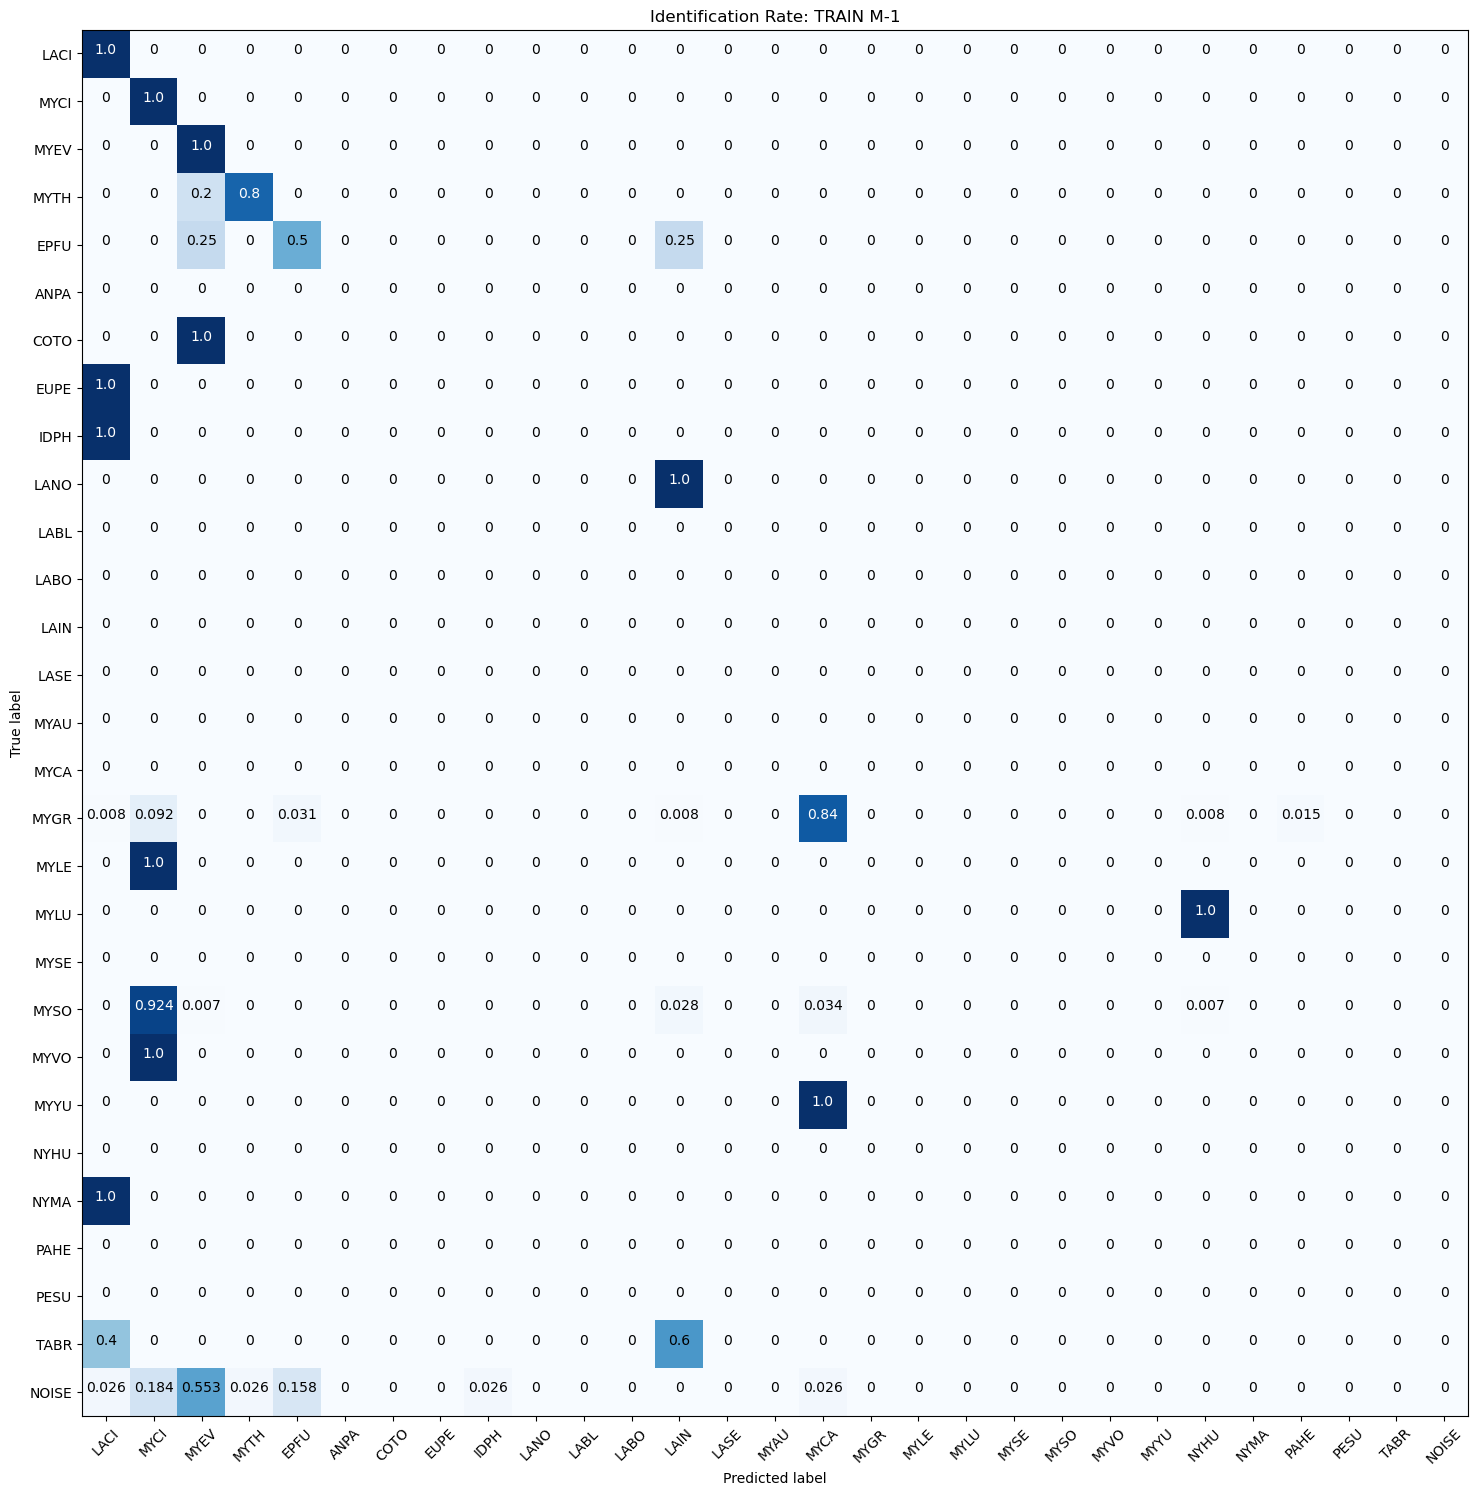

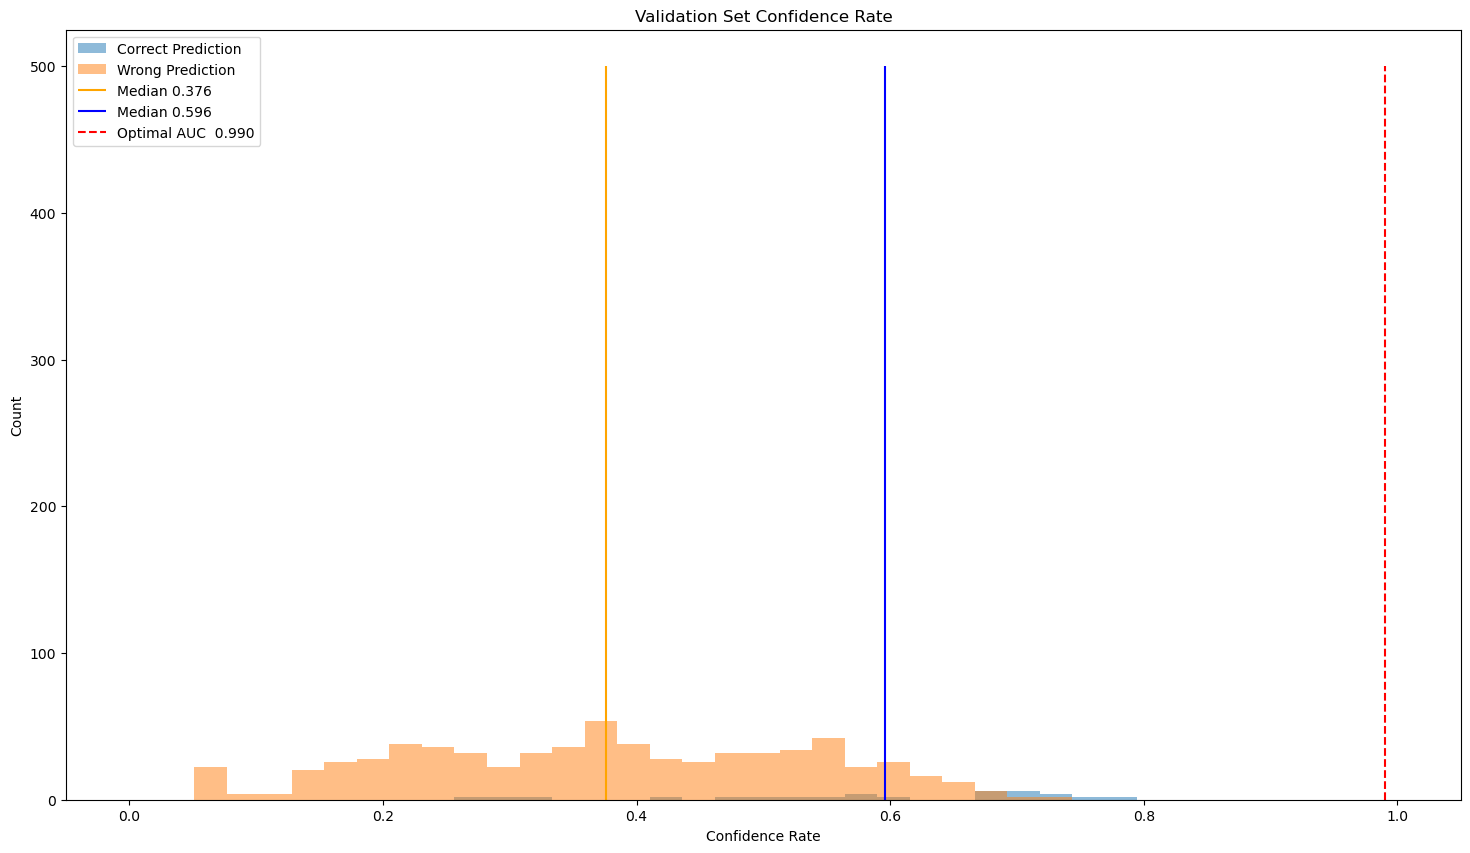

In [11]:
plot_confusion_matrix(cm, class_names=cr_sorted_keys,
                      i=model, draw=draw.upper())


# Plot the curve, based on confidence and split of correct versus wrong guesses.
plt.close('all')
figure = plt.figure(figsize=(18, 10))

sum_wrong = []
sum_correct = []
x = 0
moving_rate = 0.01
while x < 1:
    x += moving_rate
    sum_wrong.append(len([v for v in incorrect_confidences if v < x]))
    sum_correct.append(len([v for v in correct_confidences if v < x]))

for i in range(len(sum_wrong)):
    if sum_correct[i] > sum_wrong[i]:
        break

auc = i/100
w1 = np.median(incorrect_confidences)
c1 = np.median(correct_confidences)


bins = np.linspace(0, 1, 40)

plt.hist(correct_confidences, bins, alpha=0.5, label='Correct Prediction')
plt.hist(incorrect_confidences, bins, alpha=0.5, label='Wrong Prediction')

plt.vlines(w1, 0, 500, colors='orange', label='Median {:.3f}'.format(w1))
plt.vlines(c1, 0, 500, colors='blue', label='Median {:.3f}'.format(c1))
plt.vlines(auc, 0, 500, linestyles='dashed', colors='red',
           label='Optimal AUC  {:.3f}'.format(auc))

plt.ylabel('Count')
plt.xlabel('Confidence Rate')
plt.title('Validation Set Confidence Rate')

plt.legend(loc='upper left')
plt.show()